<a href="https://colab.research.google.com/github/CamiloFajardo2021/SpectralClustering/blob/main/spectral_clsutering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Spectral Clustering
[1] A tutorial on spectral clustering.Von Ulrike (2007)

## Concepts

 - Graph
 - Similarity matrix
 - Spectrum

In [ ]:
from sklearn import datasets
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import pandas as pd

iris = datasets.load_iris()

## Example

Dataset Iris

In [ ]:
data_iris = iris.data

In [ ]:
#Sepal length - Sepal Width
data_iris_red = data_iris[:,0:2]

In [ ]:
l = len(data_iris)

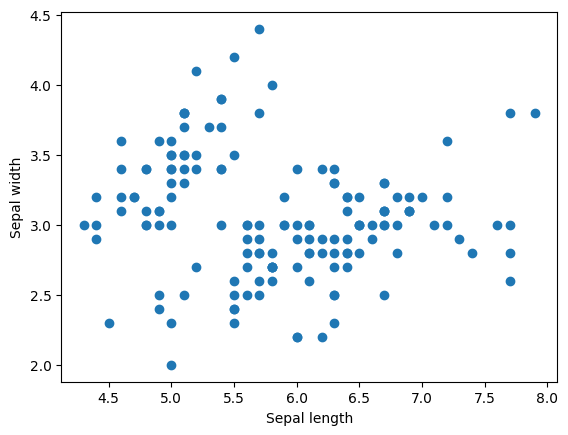

In [ ]:
plt.scatter(data_iris_red[:,0],data_iris_red[:,1])
plt.xlabel('Sepal length');
plt.ylabel('Sepal width');

Measures of Similarity (distances in the n-dimentional space of the features)
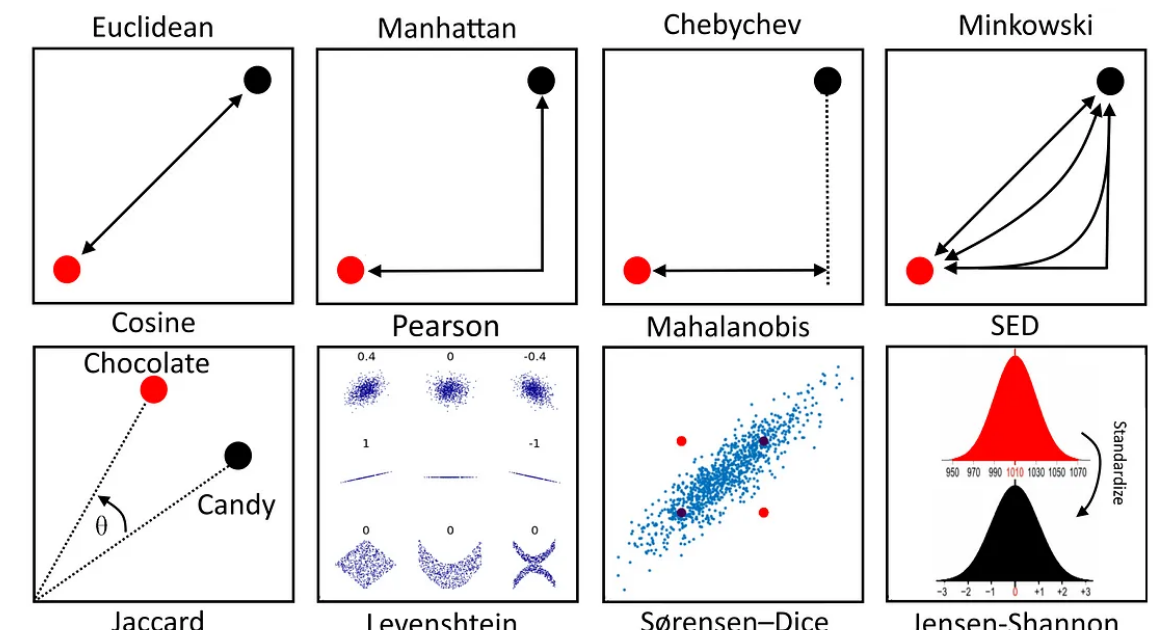

In [ ]:
from sklearn.metrics.pairwise import manhattan_distances,rbf_kernel
import scipy
def measure(p1,p2,name='euclidean'):
  if name =='euclidean':
    m = np.linalg.norm(p1-p2)
  elif name=='manhattan':
    m = sum(abs(val1-val2) for val1, val2 in zip(p1,p2))
  elif name =='minkowski':
    m = scipy.spatial.distance.minkowski(p1,p2)
  elif name == 'rbf':
    m = rbf_kernel([p1], [p2], gamma=1.)
  elif name =='cosine':
    m = 1-scipy.spatial.distance.cosine(p1,p2)
  elif name=='gaussian':
    sigma = 1
    m = np.exp(-np.linalg.norm(p1-p2)**2 / (2 * sigma**2))
  return m

## Similarity Matrix
A matrix of size $n \times n$(n the number of data).
$$ M_{i,j} = d(n_i,n_j),n_i \in N$$

In [ ]:
def built_sim_matrix(data_iris_red,k_measure='euclidean'):
  l = len(data_iris_red)
  sim_matrix = np.zeros((l,l))
  for i in range(l):
    for j in range(l):
      p1 = data_iris_red[i]
      p2 = data_iris_red[j]
      sim_matrix[i,j] = measure(p1,p2,k_measure)
  return sim_matrix
sim_matrix = built_sim_matrix(data_iris_red,'gaussian')

In [ ]:
lower_triangle_without_diagonal = np.tril(sim_matrix, k=-1)

# Flatten the array to get a 1D array of the below-diagonal entries
distances = lower_triangle_without_diagonal[lower_triangle_without_diagonal != 0]

*Threeshold*

In [ ]:
threshold = np.quantile(distances, 0.75)

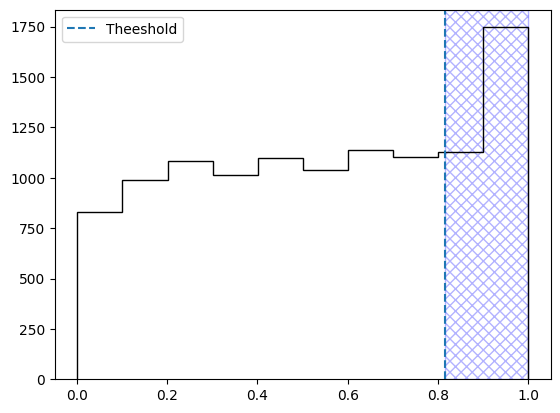

In [ ]:
fig,ax = plt.subplots()
num_x_bins = 10
plt.hist(distances,histtype = 'step',bins=num_x_bins,color='black')
hist, edges = np.histogram(distances, bins=num_x_bins)
plt.axvline(threshold,linestyle='dashed',label='Theeshold')
ax.fill_between(np.linspace(threshold,1,100) , 0, 1, where=np.linspace(threshold,1,100) > threshold,
                color='none',hatch='xxx',edgecolor='b',alpha=0.3,
                transform=ax.get_xaxis_transform())
plt.legend()
plt.show()

In [ ]:
#S = np.where(sim_matrix<threshold,sim_matrix,0)
S = np.where(sim_matrix>threshold,sim_matrix,0)

## Built graph

In [ ]:
G=nx.from_numpy_array(S)

In [ ]:
nodes = list(G.nodes())

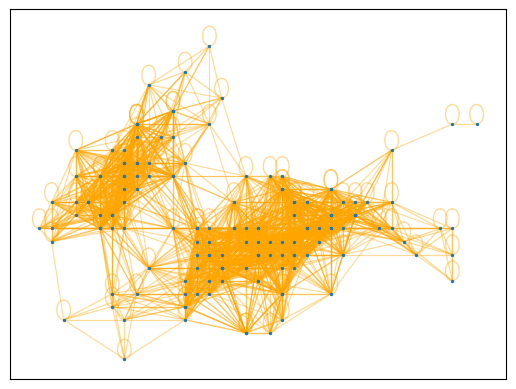

In [ ]:
pos = {nodes[j]:tuple(data_iris_red[j]) for j in range(len(nodes))}
nx.draw_networkx_nodes(G,pos,G.nodes(),node_size=2)
for (u,v,d) in G.edges(data=True):
  nx.draw_networkx_edges(G,pos,[(u,v)],width=d['weight'],edge_color='orange',alpha=0.4)

## Normalized spectral clustering according to Shi and Malik

Solve the generalized eigen problem
$$Lu = \lambda Du$$
 - L : Unnormalized Laplacian of the Graph G
 - D : Matrix of degree

In [ ]:
L = nx.laplacian_matrix(G,weight='weight').toarray()

In [ ]:
from scipy.linalg import eig
import numpy as np

def first_k_generalized_eigenvectors(A, B, k):
    """
    Solve the generalized eigenvalue problem Ax = lambda Bx and return the first k eigenvectors.

    Parameters:
    - A: Square matrix
    - B: Square matrix
    - k: Number of top eigenvectors to return

    Returns:
    - A matrix whose columns are the first k eigenvectors.
    """
    # Solve the generalized eigenvalue problem
    eigenvalues, eigenvectors = eig(A, B)

    # Sort the eigenvectors by the absolute value of their eigenvalues, descending
    idx = np.argsort(np.abs(eigenvalues))[::-1]

    # Reorder the eigenvectors according to the sorted indices
    sorted_eigenvectors = eigenvectors[:, idx]

    # Select the first k eigenvectors
    return sorted_eigenvectors[:, :k]





We calculate the first k eigenvectors and built the matrix $U\in R^{n \times k}$

\begin{bmatrix}
 \vec{u_1} & \vec{u_2} & ... & \vec{u_k}\\
\end{bmatrix}

In [ ]:
l = len(data_iris)
d = np.zeros((l,l))
np.fill_diagonal(d,[k[1] for k in nx.degree(G,weight='weight')])
U = first_k_generalized_eigenvectors(L,d,3)

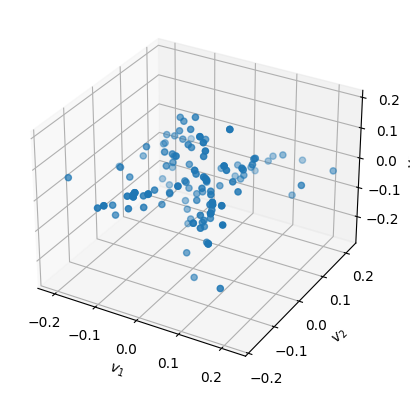

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(U[:,0],U[:,1],U[:,2])
ax.set_xlabel(r'$v_1$');
ax.set_ylabel(r'$v_2$');
ax.set_zlabel(r'$v_3$');
#plt.scatter(U[:,0],U[:,1])

Apply the k-means alghoritm in the new vectorial space

In [ ]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3, random_state=0, n_init="auto").fit(U)

In [ ]:
labels = kmeans.predict(U)

In [ ]:
labels.shape

(150,)

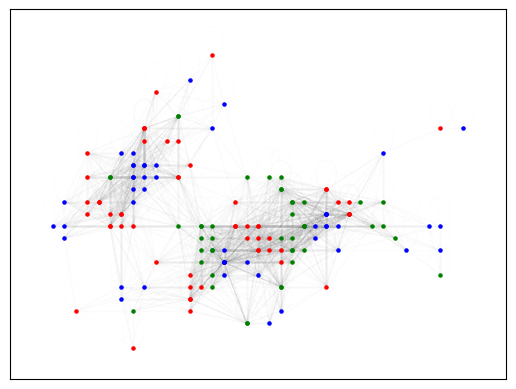

In [ ]:
lab = np.unique(labels)
color = ['red','blue','green']
W_max= np.max([d['weight'] for (u,v,d) in G.edges(data=True)])
for l in lab:
  nodes_l = [n for n in nodes if n in np.argwhere(labels==l)]
  nx.draw_networkx_nodes(G,pos,nodes_l,node_size=5,node_color=color[l])
  nx.draw_networkx_edges(G,pos,[(u,v) for (u,v) in G.edges() if u in nodes_l or v in nodes_l],edge_color='gray',alpha=0.01)

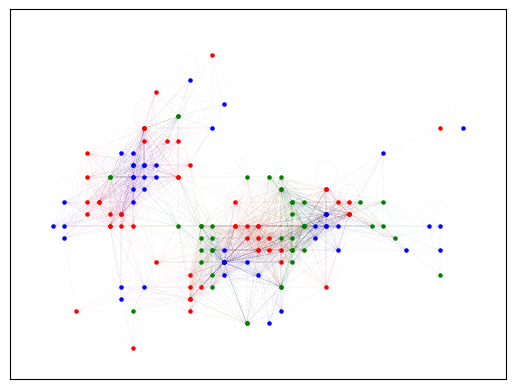

In [ ]:
for l in lab:
  nodes_l = [n for n in nodes if n in np.argwhere(labels==l)]
  G_sub = G.subgraph(nodes_l)
  edges_t = [(u,v) for (u,v) in G.edges() if u in nodes_l or v in nodes_l]
  edges_inside = list(G_sub.edges())
  edges_outside = [e for e in edges_t if e not in edges_inside]
  w_i = np.array([d['weight'] for (u,v,d) in G.edges(data=True) if (u,v) in edges_inside])
  w_o = np.array([d['weight'] for (u,v,d) in G.edges(data=True) if (u,v) in edges_outside])
  w_max = max(np.max(w_i),np.max(w_o))
  nx.draw_networkx_nodes(G_sub,pos,nodes_l,node_color=color[l],node_size=5)
  nx.draw_networkx_edges(G_sub,pos,G_sub.edges(),edge_color=color[l],width=0.3,alpha=0.05*w_i/w_max)
  nx.draw_networkx_edges(G,pos,edges_outside,edge_color=color[l],width=0.3,style='dashed',alpha=0.05*w_o/w_max)


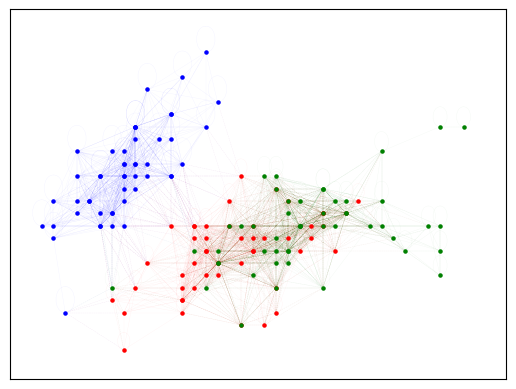

In [ ]:
color = ['blue','red','green']
for l in lab:
  nodes_l = [n for n in nodes if n in np.argwhere(iris.target==l)]
  G_sub = G.subgraph(nodes_l)
  edges_t = [(u,v) for (u,v) in G.edges() if u in nodes_l or v in nodes_l]
  edges_inside = list(G_sub.edges())
  edges_outside = [e for e in edges_t if e not in edges_inside]
  w_i = np.array([d['weight'] for (u,v,d) in G.edges(data=True) if (u,v) in edges_inside])
  w_o = np.array([d['weight'] for (u,v,d) in G.edges(data=True) if (u,v) in edges_outside])
  w_max = max(np.max(w_i),np.max(w_o))
  nx.draw_networkx_nodes(G_sub,pos,nodes_l,node_color=color[l],node_size=5)
  nx.draw_networkx_edges(G_sub,pos,G_sub.edges(),edge_color=color[l],width=0.3,alpha=0.05*w_i/w_max)
  nx.draw_networkx_edges(G,pos,edges_outside,edge_color=color[l],width=0.3,style='dashed',alpha=0.05*w_o/w_max)

## Effect of the threshold

In [ ]:
def spectral(data_iris_red,k_measure,ax,q=0.75,draw=True):
  sim_matrix = built_sim_matrix(data_iris_red,k_measure)
  lower_triangle_without_diagonal = np.tril(sim_matrix, k=-1)

# Flatten the array to get a 1D array of the below-diagonal entries
  distances = lower_triangle_without_diagonal[lower_triangle_without_diagonal != 0]
  threshold = np.quantile(distances, q)
  S = np.where(sim_matrix>threshold,sim_matrix,0)
  G=nx.from_numpy_array(S)
  #print(len(G.edges()))
  nodes = list(G.nodes())
  pos = {nodes[j]:tuple(data_iris_red[j])[:2] for j in range(len(nodes))}
  l = len(data_iris_red)
  d = np.zeros((l,l))
  L = nx.laplacian_matrix(G,weight='weight').todense()
  np.fill_diagonal(d,[k[1] for k in nx.degree(G,weight='weight')])
  U = first_k_generalized_eigenvectors(L,d,3)
  kmeans = KMeans(n_clusters=3, random_state=0, n_init="auto").fit(U)
  labels = kmeans.predict(U)
  if draw==True:
    for l in lab:
      nodes_l = [n for n in nodes if n in np.argwhere(labels==l)]
      G_sub = G.subgraph(nodes_l)
      edges_t = [(u,v) for (u,v) in G.edges() if u in nodes_l or v in nodes_l]
      edges_inside = list(G_sub.edges())
      edges_outside = [e for e in edges_t if e not in edges_inside]
      w_i = np.array([d['weight'] for (u,v,d) in G.edges(data=True) if (u,v) in edges_inside])
      w_o = np.array([d['weight'] for (u,v,d) in G.edges(data=True) if (u,v) in edges_outside])
      if len(w_i)>1 and len(w_o)>1:
        w_max = max(np.max(w_i),np.max(w_o))
      else:
        w_max = 1
      nx.draw_networkx_nodes(G_sub,pos,nodes_l,node_color=color[l],node_size=5,ax=ax)
      nx.draw_networkx_edges(G_sub,pos,G_sub.edges(),edge_color=color[l],width=0.3,alpha=0.05*w_i/w_max,ax=ax)
      nx.draw_networkx_edges(G,pos,edges_outside,edge_color=color[l],width=0.3,style='dashed',alpha=0.05*w_o/w_max,ax=ax)
  return labels

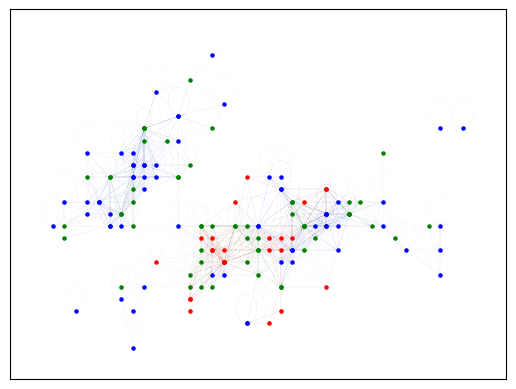

In [ ]:
fig,ax = plt.subplots()
L = spectral(data_iris_red,'gaussian',ax,q=0.87)

In [ ]:
from sklearn.metrics import accuracy_score
from itertools import permutations
y_true = iris.target
y_pred = L
def get_labels(y_true,y_pred):
  uniques = list(set(y_true))
  L = list(permutations(uniques))
  acc = []
  for l in L:
    dic_aux = {j:l[j] for j in range(len(uniques))}
    y_pred_aux = list(map(lambda x:l[x],y_pred))
    a = accuracy_score(y_true, y_pred_aux)
    acc.append(a)
  l = L[np.where(acc==np.max(acc))[0][0]]
  dic_aux = {j:l[j] for j in range(len(uniques))}
  return map(lambda x:l[x],y_pred),np.max(acc)

In [ ]:
labels,acc = get_labels(y_true,y_pred)

In [ ]:
print(acc)

0.43333333333333335


In [ ]:
Q = np.linspace(0.3,1,12)
Acc = []
for q in Q:
  L = spectral(data_iris,'gaussian',ax,q=q)
  labels,acc = get_labels(y_true,L)
  Acc.append(acc)

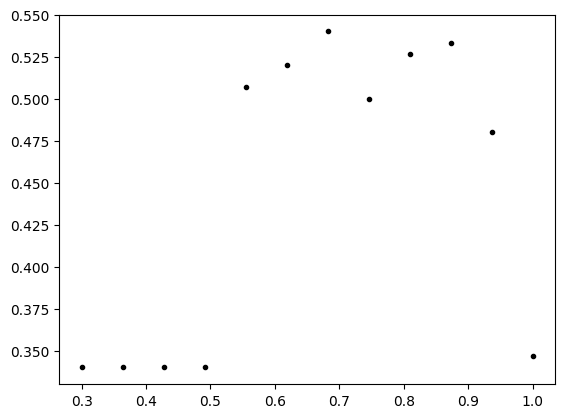

In [ ]:
plt.plot(Q,Acc,'.k')

## Accuracy spectral clustering vs Kmeans

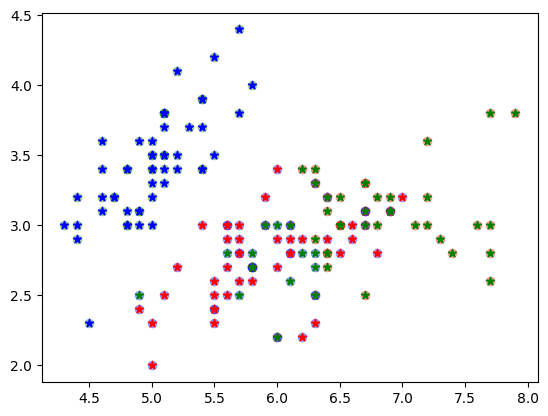

In [ ]:
from sklearn.cluster import SpectralClustering
kmeans = SpectralClustering(n_clusters=3, random_state=0).fit(data_iris[:,:4])
labels = kmeans.fit_predict(data_iris[:,:4])
plt.scatter(data_iris_red[labels==0][:,0],data_iris_red[labels==0][:,1],color='red',alpha=0.3)
plt.scatter(data_iris_red[labels==1][:,0],data_iris_red[labels==1][:,1],color='blue',alpha=0.3)
plt.scatter(data_iris_red[labels==2][:,0],data_iris_red[labels==2][:,1],color='green',alpha=0.3)
plt.scatter(data_iris_red[iris.target==0][:,0],data_iris_red[iris.target==0][:,1],color='blue',marker='*')
plt.scatter(data_iris_red[iris.target==1][:,0],data_iris_red[iris.target==1][:,1],color='red',marker='*')
plt.scatter(data_iris_red[iris.target==2][:,0],data_iris_red[iris.target==2][:,1],color='green',marker='*')


In [ ]:
from sklearn.metrics import accuracy_score,confusion_matrix
y_true = iris.target
y_pred = labels
Labels,acc = get_labels(y_true,y_pred)

In [ ]:
print('Accuracy Spectral Clustering : ', acc)
confusion_matrix(y_true, list(Labels))

Accuracy Spectral Clustering :  0.9


array([[50,  0,  0],
       [ 0, 50,  0],
       [ 0, 15, 35]])

In [ ]:
kmeans = KMeans(n_clusters=3, random_state=0, n_init="auto").fit(data_iris[:,:4])
y_pred = kmeans.predict(data_iris[:,:4])
Labels,acc = get_labels(y_true,y_pred)

In [ ]:
print('Accuracy K-means : ', acc)
confusion_matrix(y_true, list(Labels))

Accuracy K-means :  0.8866666666666667


array([[50,  0,  0],
       [ 0, 47,  3],
       [ 0, 14, 36]])